# Load and preprocess the data

In [1]:
from sklearn.datasets import load_diabetes
data = load_diabetes()

### Exploring the data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

In [3]:
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


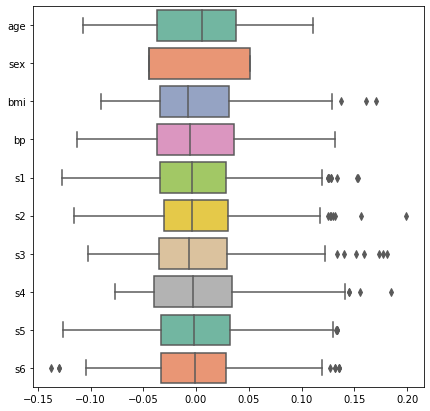

In [4]:
plt.figure(figsize=(7,7))
ax = sns.boxplot(data=df, orient='h', palette='Set2')

Looking at the plots, the data is aleady being transformed, so no need to scale it again. 
min max when the distribution is not normal. else Robust Scaler

#### Handliing outliers

If there are `Nan` values, if the dataset is very big, we can drop them, if instead the dataset is not so big but there are a lot of outliers, we replace them with the median, in there are not so many outliers we replace them with the mean. 
**LOOK AT 02_A_FEATURE_PROCESSING FOR DETAILS**

In [5]:
# data = data.fillna(data.mean())
# data = data.fillna(data.median())

# 2) Split the data

In [6]:
from sklearn.model_selection import train_test_split

X = df.values
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


print(len(X_train), len(X_test))

331 111


Normal equation

In [7]:
X_b = np.c_[np.ones((len(X_train), 1)), X_train] # add x0 = 1 to each instance  <331x2>
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train) # NORMAL EQUATION

In [8]:
print(theta_best)

[ 153.06798218  -43.26774487 -208.67053951  593.39797213  302.89814903
 -560.27689824  261.47657106   -8.83343952  135.93715156  703.22658427
   28.34844354]


Normal equation with ridge:

In [9]:
X_b = np.c_[np.ones((len(X_train), 1)), X_train] # add x0 = 1 to each instance, shape 331 x 11

def ridge_theta_best(alpha: float):
    return np.linalg.inv(X_b.T.dot(X_b) + alpha * np.identity(X_b.shape[1])).dot(X_b.T).dot(y_train)

theta_best = ridge_theta_best(0.1)

In [10]:
X_test_b = np.c_[np.ones((len(X_test), 1)), X_test]

In [11]:
print(theta_best)

[ 152.81757257  -24.57549854 -176.83641954  542.0445565   278.66386169
  -64.29718667 -106.40470489 -203.46068322  103.51570183  455.47841522
   57.87535191]


In [12]:
y_pred_norm = X_test_b.dot(theta_best)
# print(y_pred)

Measuring the model

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

r2_norm = r2_score(y_test, y_pred_norm)
rmse_norm = sqrt(mean_squared_error(y_test, y_pred_norm))

print('r2 score: {} (higher is better), root mean squared error: {} (lower is better)'.format(r2_norm, rmse_norm))

r2 score: 0.3690726419323702 (higher is better), root mean squared error: 55.96592140548164 (lower is better)


# 3) Using `sklearn.linear_model` implementation

In [14]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
model = lin_reg.fit(X_train, y_train)
print("Intercept={}, Slope={}".format(lin_reg.intercept_, lin_reg.coef_))

Intercept=153.06798218266258, Slope=[ -43.26774487 -208.67053951  593.39797213  302.89814903 -560.27689824
  261.47657106   -8.83343952  135.93715156  703.22658427   28.34844354]


Comparing with `theta_best` values, they are the same

In [15]:
model.score(X_test, y_test)

0.35940090989715534

The `LinearRegression` class performs a `LeastSquare` optimization task, which can be called directly

In [16]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_test_b, y_test, rcond=1e-6)
theta_best_svd

array([  148.60939713,   122.84075063,  -328.53759576,   306.52890008,
         342.13978386, -2054.22700228,  1626.27788372,   586.48941858,
         262.9680206 ,  1082.70817482,   187.58052342])

# 4) BatchGradiantDescent (not sklearn implementation)

In [17]:
X_train.shape

(331, 10)

In [18]:
eta = 0.1 # learning rate 
n_iterations = 100
m=len(X_train) # number of samples on the training set

theta_grad = np.random.randn(11,1) # random initialization <11x1>, 11 because the features are 10+theta column=11

for iteration in range(n_iterations):
    pred = np.array(X_b.dot(theta_grad))
    diff = pred - y_train.reshape(-1,1)
    gradients = 2/m * X_b.T.dot(diff) 
    theta_grad = theta_grad - eta * gradients
    
print(theta_grad)

[[152.00263261]
 [ 11.12898138]
 [  3.02657658]
 [ 44.97159716]
 [ 31.80833582]
 [ 13.04781967]
 [ 11.20414673]
 [-29.96655421]
 [ 29.77402589]
 [ 43.52299896]
 [ 28.93878501]]


In [19]:
y_pred_grad = X_test_b.dot(theta_grad)

In [20]:
r2_grad = r2_score(y_test, y_pred_grad)
rmse_grad = sqrt(mean_squared_error(y_test, y_pred_grad))

print('r2 score: {} (higher is better), root mean squared error: {} (lower is better)'.format(r2_grad, rmse_grad))

r2 score: 0.10666997372789522 (higher is better), root mean squared error: 66.59474254179345 (lower is better)


In [21]:
def gradient_descent_prediction(learning_rate: float) -> float:
    eta = learning_rate
    n_iterations = 100
    m=len(y_train)

    theta = np.random.randn(11,1) # random initialization <11x1>
    y_pred = 0

    for iteration in range(n_iterations):
        predictions = np.array(X_b.dot(theta))
        difference = np.subtract(predictions, y_train.reshape(-1,1))
        gradients = 2/m * X_b.T.dot(difference)
        theta = theta - eta * gradients
        y_pred = X_test_b.dot(theta)
    return y_pred

In [22]:
best_score = 0
best_parameter = 100000
# note the values have been tuned in the list starting from the
# general [0.001, 0.01, 0.1, 1, 10, 100].
for eta in [0.9, 0.92, 0.94, 0.96, 0.98, 1]:
    # for each combination of parameters, evaluate the model
    y_pred_grad = gradient_descent_prediction(eta)
    new_score = r2_score(y_test,y_pred_grad)
    if new_score > best_score:
        best_score = new_score
        best_parameter = eta

print("Best score r2: {:.7f}".format(best_score))
print("Best parameters: {}".format(best_parameter))

Best score r2: 0.3573483
Best parameters: 0.98


# Stochastic gradiant descent (not sklearn implementation)

In [23]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

m=100 #number of samples on the training set

def learning_schedule(t): 
      return t0/(t+t1)

theta_stoc = np.random.randn(11,1) # random initialization

for epoch in range(n_epochs): 
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta_stoc) - yi)
        eta = learning_schedule(epoch * m + i)
        theta_stoc = theta_stoc - eta * gradients
print(theta_stoc)

[[130.61172445]
 [-17.8535517 ]
 [ -3.92347162]
 [-25.33249706]
 [-22.02162803]
 [  3.98896936]
 [  7.77591602]
 [ -0.83374206]
 [ -1.60418268]
 [ -8.3016588 ]
 [  6.71786812]]


By convention we iterate by rounds of `m` iterations; each round is called an `epoch`. 

* Batch Gradient Descent (above) iterated 1,000 times through the whole training set
* Stochastic Gradient Descent goes through the training set only 50 times and reaches a fairly good solution

# Plotting learning curves

/home/christian/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
<ipython-input-24-9c43bb48b177>:20: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(np.sqrt(val_errors), color+'-', linewidth=3, label="test_"+model_type)
/home/christian/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
<ipython-input-24-9c43bb48b177>:20: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(np.sqrt(val_errors), color+'-', linewidth=3, label="test_"+model_type)


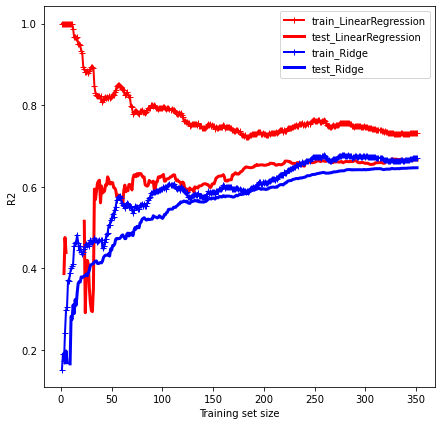

In [24]:
from sklearn.linear_model import Ridge

plt.figure(figsize=(7,7))

def plot_learning_curves(model, X, y, model_type, color):
  
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) 
    train_errors, val_errors = [], []
  
    for m in range(1, len(X_train)):

        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)

        train_errors.append(r2_score(y_train[:m], y_train_predict))
        val_errors.append(r2_score(y_val, y_val_predict))
  
    plt.plot(np.sqrt(train_errors), color+'-+', linewidth=2, label="train_"+model_type)
    plt.plot(np.sqrt(val_errors), color+'-', linewidth=3, label="test_"+model_type)


lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y, "LinearRegression", color='r')

ridge_reg = Ridge(alpha=1)
plot_learning_curves(ridge_reg, X, y, "Ridge", color='b')

plt.xlabel('Training set size')
plt.ylabel('R2')
plt.legend()